In [13]:
import sys
sys.path.append("../")
sys.path.append("../../../assets")


# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import bayesflow as beef
import pickle

from experiments import RandomWalkDiffusionExperiment
from diffusion.models import RandomWalkDiffusion
from configuration import default_num_steps

In [54]:
# If set to False, existing results will be loaded
# Set to True if you want to re-run the experiments
SIMULATE_DATA = False
TRAIN_NETWORKS = False
FIT_MODEL = False

NUM_SIM = 200
NUM_STEPS = 400
NUM_SAMPLES = 2000

NEURAL_COLOR = '#852626'
COMPARISON_COLOR = '#133a76'
ALPHA = 0.6
PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time']
PARAM_NAMES  = [r'$v$', r'$a$', r'$\tau$']
SUBFIGURE_TITLES = ["Static DDM", "Stationary Variablity DDM",
                    "Non-Stationary Variability DDM", "Regime Switching DDM"]

FONT_SIZE_1 = 22
FONT_SIZE_2 = 18
FONT_SIZE_3 = 16

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"

In [15]:
random_walk_ddm = RandomWalkDiffusion(num_steps=default_num_steps)
experiment = RandomWalkDiffusionExperiment(random_walk_ddm)

INFO:root:Performing 2 pilot runs with the random_walk_diffusion_model model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 400, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 400)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 400, 3)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.
INFO:root:Loaded loss history from ../checkpoints/simulation_study/history_75.pkl.
INFO:root:Networks loaded from ../checkpoints/simulation_study/ckpt-75
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


## Simulation

In [16]:
if SIMULATE_DATA:
    from diffusion.models import StaticDiffusion, StationaryDiffusion, RegimeSwitchingDiffusion
    static_ddm = StaticDiffusion()
    stationary_ddm = StationaryDiffusion()
    regime_switching_ddm = RegimeSwitchingDiffusion()
    static_ddm_sim = static_ddm.generate(NUM_SIM)
    stationary_ddm_sim = stationary_ddm.generate(NUM_SIM)
    random_walk_ddm_sim = random_walk_ddm.generate(NUM_SIM)
    regime_switching_ddm_sim = regime_switching_ddm.generate(NUM_SIM)
    with open('../data/static_ddm_sim_200.pkl', 'wb') as f:
        pickle.dump(static_ddm_sim, f)
    with open('../data/stationary_ddm_sim_200.pkl', 'wb') as f:
        pickle.dump(stationary_ddm_sim, f)
    with open('../data/random_walk_ddm_sim_200.pkl', 'wb') as f:
        pickle.dump(random_walk_ddm_sim, f)
    with open('../data/regime_switching_ddm_sim_200.pkl', 'wb') as f:
        pickle.dump(regime_switching_ddm_sim, f)
else:
    with open('../data/static_ddm_sim_200.pkl', 'rb') as f:
        static_ddm_sim = pickle.load(f)
    with open('../data/stationary_ddm_sim_200.pkl', 'rb') as f:
        stationary_ddm_sim = pickle.load(f)
    with open('../data/random_walk_ddm_sim_200.pkl', 'rb') as f:
        random_walk_ddm_sim = pickle.load(f)
    with open('../data/regime_switching_ddm_sim_200.pkl', 'rb') as f:
        regime_switching_ddm_sim = pickle.load(f)

## Training

In [17]:
if TRAIN_NETWORKS:
    history = experiment.run(
        epochs=75, 
        iterations_per_epoch=1000,
        batch_size=16
    )
else:
    history = experiment.trainer.loss_history.get_plottable()

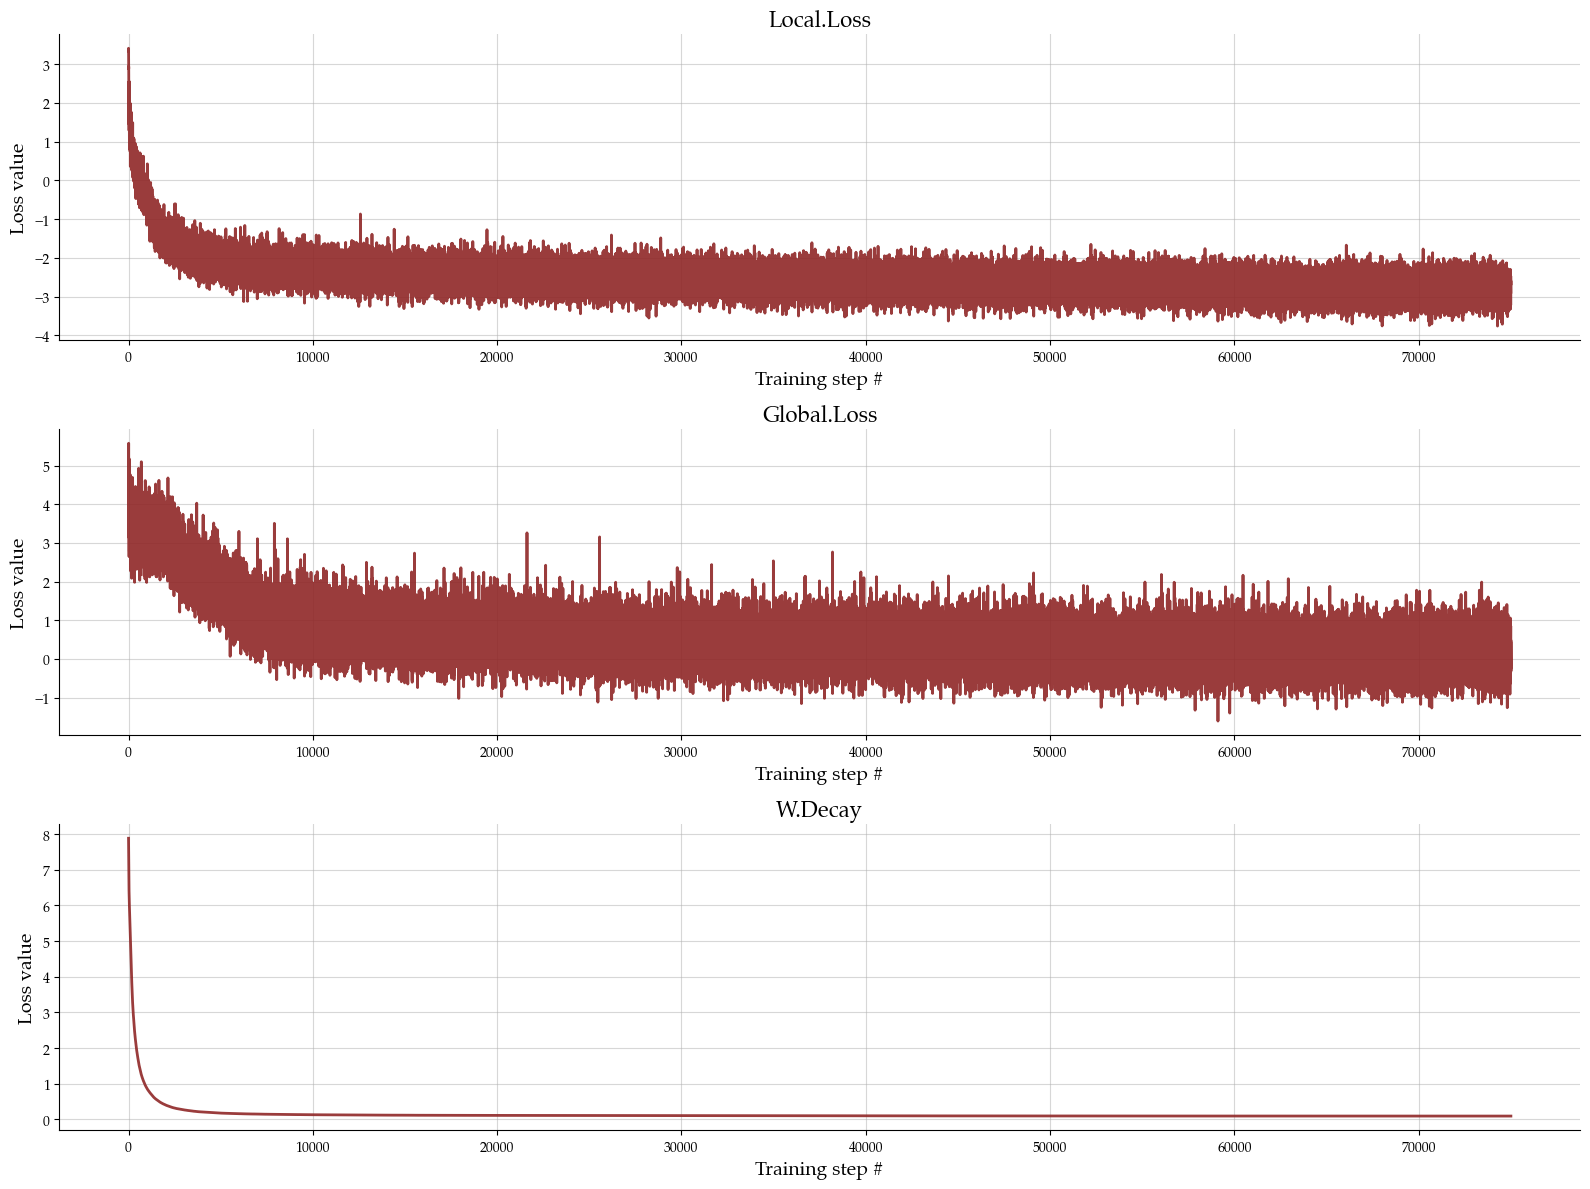

In [18]:
f = beef.diagnostics.plot_losses(history)

## Evaluation

In [19]:
with tf.device('/cpu:0'):
    if FIT_MODEL:
        local_post_static = np.zeros((NUM_SIM, NUM_STEPS, NUM_SAMPLES, 3))
        global_post_static = np.zeros((NUM_SIM, NUM_SAMPLES, 3))
        local_post_stationary = np.zeros((NUM_SIM, NUM_STEPS, NUM_SAMPLES, 3))
        global_post_stationary = np.zeros((NUM_SIM, NUM_SAMPLES, 3))
        local_post_random_walk = np.zeros((NUM_SIM, NUM_STEPS, NUM_SAMPLES, 3))
        global_post_random_walk = np.zeros((NUM_SIM, NUM_SAMPLES, 3))
        local_post_regime_switching = np.zeros((NUM_SIM, NUM_STEPS, NUM_SAMPLES, 3))
        global_post_regime_switching = np.zeros((NUM_SIM, NUM_SAMPLES, 3))


        for sim in range(NUM_SIM):
            # static ddm
            post_samples = experiment.amortizer.sample(
                {'summary_conditions': static_ddm_sim['sim_data'][sim:sim+1, :, None]},
                NUM_SAMPLES
            )
            local_post_static[sim] = post_samples['local_samples']
            global_post_static[sim] = post_samples['global_samples']
            # stationary ddm
            post_samples = experiment.amortizer.sample(
                {'summary_conditions': stationary_ddm_sim['sim_data'][sim:sim+1, :, None]},
                NUM_SAMPLES
            )
            local_post_stationary[sim] = post_samples['local_samples']
            global_post_stationary[sim] = post_samples['global_samples']
            # random walk ddm
            post_samples = experiment.amortizer.sample(
                {'summary_conditions': random_walk_ddm_sim['sim_data'][sim:sim+1, :, None]},
                NUM_SAMPLES
            )
            local_post_random_walk[sim] = post_samples['local_samples']
            global_post_random_walk[sim] = post_samples['global_samples']
            # regime switching ddm
            post_samples = experiment.amortizer.sample(
                {'summary_conditions': regime_switching_ddm_sim['sim_data'][sim:sim+1, :, None]},
                NUM_SAMPLES
            )
            local_post_regime_switching[sim] = post_samples['local_samples']
            global_post_regime_switching[sim] = post_samples['global_samples']
            
        np.save('../data/local_post_static.npy', local_post_static)
        np.save('../data/global_post_static.npy', global_post_static)
        np.save('../data/local_post_stationary.npy', local_post_stationary)
        np.save('../data/global_post_stationary.npy', global_post_stationary)
        np.save('../data/local_post_random_walk.npy', local_post_random_walk)
        np.save('../data/global_post_random_walk.npy', global_post_random_walk)
        np.save('../data/local_post_regime_switching.npy', local_post_regime_switching)
        np.save('../data/global_post_regime_switching.npy', global_post_regime_switching)

    else:
        local_post_static = np.load('../data/local_post_static.npy')
        global_post_static = np.load('../data/global_post_static.npy')
        local_post_stationary = np.load('../data/local_post_stationary.npy')
        global_post_stationary = np.load('../data/global_post_stationary.npy')
        local_post_random_walk = np.load('../data/local_post_random_walk.npy')
        global_post_random_walk = np.load('../data/global_post_random_walk.npy')
        local_post_regime_switching = np.load('../data/local_post_regime_switching.npy')
        global_post_regime_switching = np.load('../data/global_post_regime_switching.npy')
        

In [20]:
# unscale posterior samples
local_post_static = local_post_static * random_walk_ddm.local_prior_stds + random_walk_ddm.local_prior_means
local_post_stationary = local_post_stationary * random_walk_ddm.local_prior_stds + random_walk_ddm.local_prior_means
local_post_random_walk = local_post_random_walk * random_walk_ddm.local_prior_stds + random_walk_ddm.local_prior_means
local_post_regime_switching = local_post_regime_switching * random_walk_ddm.local_prior_stds + random_walk_ddm.local_prior_means

In [21]:
# calculate posterior means
local_post_static_means = local_post_static.mean(axis=2)
local_post_stationary_means = local_post_stationary.mean(axis=2)
local_post_random_walk_means = local_post_random_walk.mean(axis=2)
local_post_regime_switching_means = local_post_regime_switching.mean(axis=2)
# calculate posterior stds
local_post_static_stds = local_post_static.std(axis=2)
local_post_stationary_stds = local_post_stationary.std(axis=2)
local_post_random_walk_stds = local_post_random_walk.std(axis=2)
local_post_regime_switching_stds = local_post_regime_switching.std(axis=2)

In [22]:
post_mean_summaries = np.array([local_post_static_means, local_post_stationary_means,
                local_post_random_walk_means, local_post_regime_switching_means])
post_std_summaries = np.array([local_post_static_stds, local_post_stationary_stds,
                local_post_random_walk_stds, local_post_regime_switching_stds])

true_static = np.repeat(static_ddm_sim['prior_draws'][:, None, :], NUM_STEPS, axis=1)
true_stationary = np.repeat(stationary_ddm_sim['prior_draws'][:, None, :3], NUM_STEPS, axis=1)
true_summary = np.array([true_static, true_stationary,
                random_walk_ddm_sim['local_prior_draws'], regime_switching_ddm_sim['prior_draws']])

/var/folders/bv/vht4zx991wd5ygpm2yz12gd40000gn/T/ipykernel_23293/1520643811.py:42: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  subfig.subplots_adjust(hspace=0.5)


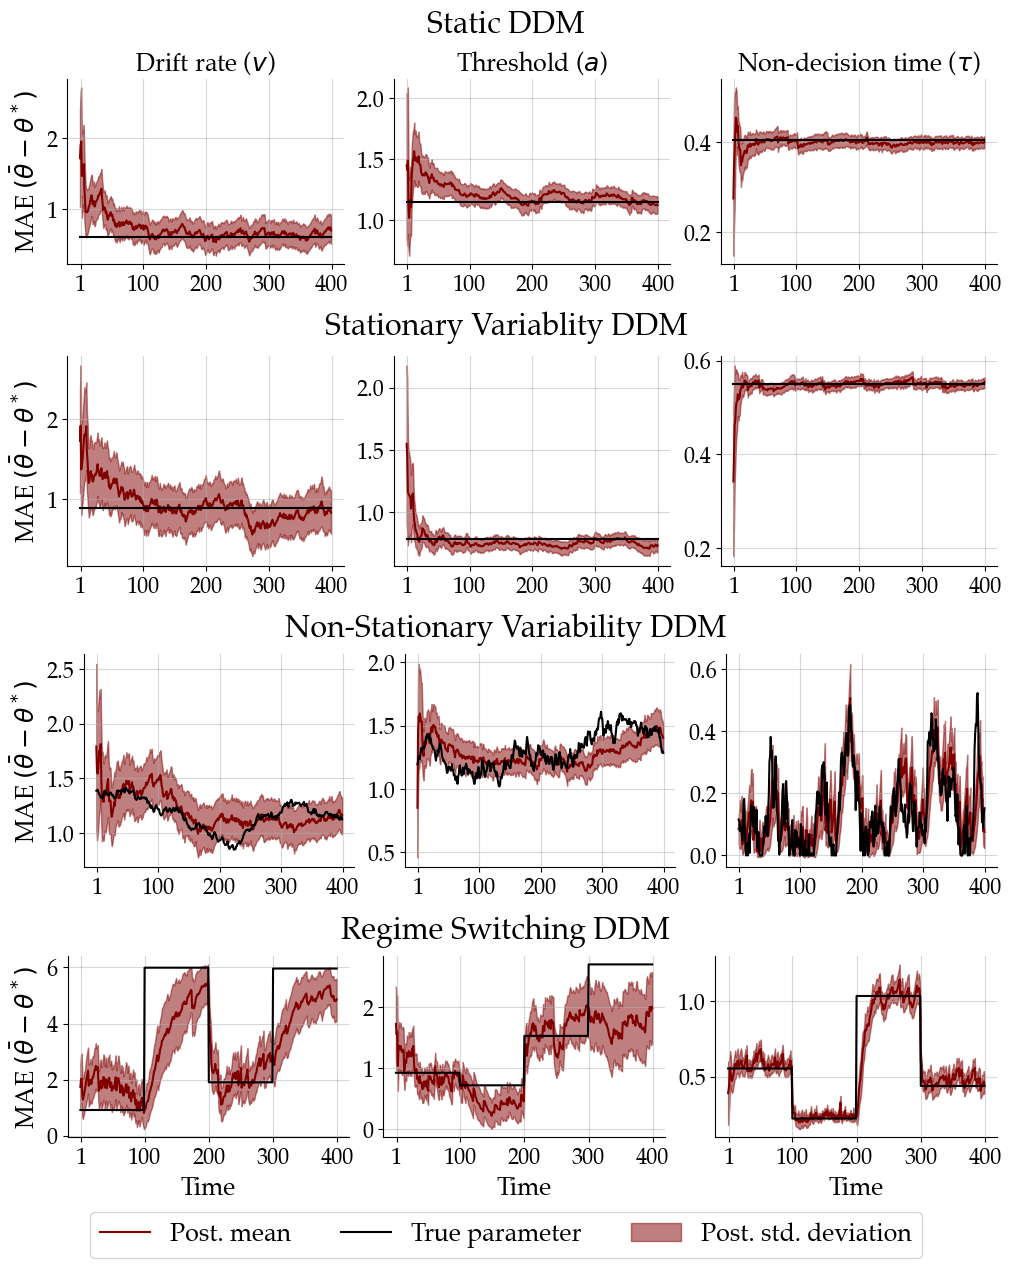

In [140]:
which = 29
fig = plt.figure(constrained_layout=True, figsize=(10, 12))

# create 4x1 subfigs
subfigs = fig.subfigures(nrows=4, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(SUBFIGURE_TITLES[row], fontsize=FONT_SIZE_1, fontweight='bold')

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        ax.plot(
            np.arange(NUM_STEPS), post_mean_summaries[row, which, :, col],
            color = "maroon", label = "Post. mean"
        )

        ax.plot(
            np.arange(NUM_STEPS), true_summary[row, which, :, col],
            color = "black", label = "True parameter"
        )
        
        ax.fill_between(
            np.arange(NUM_STEPS),
            post_mean_summaries[row, which, :, col] - post_std_summaries[row, which, :, col],
            post_mean_summaries[row, which, :, col] + post_std_summaries[row, which, :, col],
            alpha = 0.5,
            color = "maroon",
            label = "Post. std. deviation"
        )
        ax.grid(alpha=0.5)
        
        if row == 0:
            ax.set_title(PARAM_LABELS[col] + ' ({})'.format(PARAM_NAMES[col]), fontsize=FONT_SIZE_2)
        if row == 3:
            ax.set_xlabel('Time', fontsize=FONT_SIZE_2)
        if col == 0:
            ax.set_ylabel(r'MAE $(\bar{\theta} - \theta^*)$', fontsize=FONT_SIZE_2)
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
        ax.set_xticks((1, 100, 200, 300, 400))
        
        if row == 3 and col == 0:
            subfig.subplots_adjust(hspace=0.5)
            subfig.legend(
                bbox_to_anchor=(0.5, -0.1),
                fontsize=FONT_SIZE_2,
                loc="center",
                ncol=3
                )
sns.despine()
f.tight_layout()

plt.savefig('../plots/simulation_study_exemplar.png', dpi=300, bbox_inches='tight')

In [56]:
# calculate absolute error between true and estimated parameter
abs_error_static = np.empty((NUM_SIM, NUM_STEPS, 3))
abs_error_stationary = np.empty((NUM_SIM, NUM_STEPS, 3))
for i in range(NUM_SIM):
    abs_error_static[i] = np.abs(local_post_static_means[i] - static_ddm_sim['prior_draws'][i])
    abs_error_stationary[i] = np.abs(local_post_stationary_means[i] - stationary_ddm_sim['prior_draws'][i, :3])
abs_error_random_walk = np.abs(local_post_random_walk_means - random_walk_ddm_sim['local_prior_draws'])
abs_error_regime_switching = np.abs(local_post_regime_switching_means - regime_switching_ddm_sim['prior_draws'])

In [57]:
# aggregate absolute error over simulations
abs_error_static_mean = abs_error_static.mean(axis=0)
abs_error_static_std = abs_error_static.std(axis=0)
abs_error_stationary_mean = abs_error_stationary.mean(axis=0)
abs_error_stationary_std = abs_error_stationary.std(axis=0)
abs_error_random_walk_mean = abs_error_random_walk.mean(axis=0)
abs_error_random_walk_std = abs_error_random_walk.std(axis=0)
abs_error_regime_switching_mean = abs_error_regime_switching.mean(axis=0)
abs_error_regime_switching_std = abs_error_regime_switching.std(axis=0)

In [58]:
mean_summaries = np.array([abs_error_static_mean, abs_error_stationary_mean,
                abs_error_random_walk_mean, abs_error_regime_switching_mean])
std_summaries = np.array([abs_error_static_std, abs_error_stationary_std,
                abs_error_random_walk_std, abs_error_regime_switching_std])

In [59]:
subfigure_titles = ["Static DDM", "Stationary Variablity DDM",
                    "Non-Stationary Variability DDM", "Regime Switching DDM"]

/var/folders/bv/vht4zx991wd5ygpm2yz12gd40000gn/T/ipykernel_23293/2461295386.py:34: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  subfig.subplots_adjust(hspace=0.5)


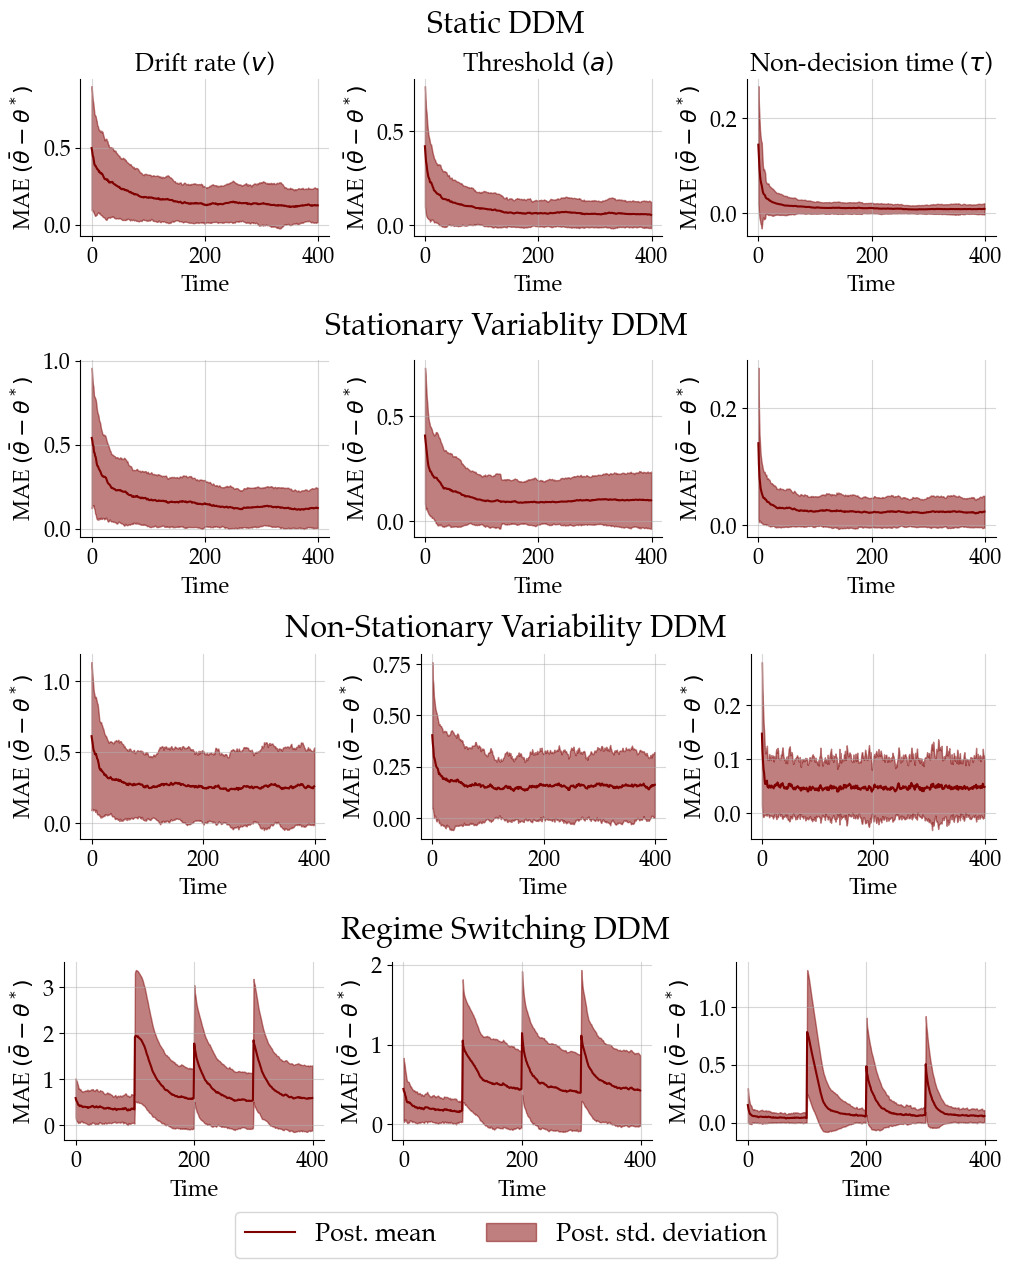

In [143]:
fig = plt.figure(constrained_layout=True, figsize=(10, 12))

# create 4x1 subfigs
subfigs = fig.subfigures(nrows=4, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(subfigure_titles[row], fontsize=FONT_SIZE_1, fontweight='semibold')

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        ax.plot(
            np.arange(NUM_STEPS), mean_summaries[row, :, col],
            color = "maroon", label="Post. mean"
        )
        
        ax.fill_between(
            np.arange(NUM_STEPS),
            mean_summaries[row, :, col] - std_summaries[row, :, col],
            mean_summaries[row, :, col] + std_summaries[row, :, col],
            alpha = 0.5,
            color = "maroon",
            label="Post. std. deviation"
        )
        ax.grid(alpha=0.5)
        
        if row == 0:
            ax.set_title(PARAM_LABELS[col] + ' ({})'.format(PARAM_NAMES[col]), fontsize=FONT_SIZE_2)
            
        ax.set_xlabel('Time', fontsize=FONT_SIZE_3)
        ax.set_ylabel(r'MAE $(\bar{\theta} - \theta^*)$', fontsize=FONT_SIZE_3)
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
        
        if row == 3 and col == 0:
            subfig.subplots_adjust(hspace=0.5)
            subfig.legend(
                bbox_to_anchor=(0.5, -0.1),
                fontsize=FONT_SIZE_2,
                loc="center",
                ncol=3
                )
    
        
sns.despine()
f.tight_layout()

plt.savefig('../plots/simulation_study_mae.png', dpi=300, bbox_inches='tight')